A simple implementation of RGDR workflow.

In [1]:
import s2spy.time
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

# New packages that had to be installed
# scipy
# joblib
# statsmodels
# matplotlib (optional)
# cartopy (optional)


1. Prepare calendar

In [2]:
calendar = s2spy.time.AdventCalendar((8, 31), freq = "30d")
intervals = calendar.map_years(2010, 2012)
intervals

i_interval,0,1,2,3,4,5,6,7,8,9,10,11
anchor_year,,,,,,,,,,,,
2012,"(2012-08-01, 2012-08-31]","(2012-07-02, 2012-08-01]","(2012-06-02, 2012-07-02]","(2012-05-03, 2012-06-02]","(2012-04-03, 2012-05-03]","(2012-03-04, 2012-04-03]","(2012-02-03, 2012-03-04]","(2012-01-04, 2012-02-03]","(2011-12-05, 2012-01-04]","(2011-11-05, 2011-12-05]","(2011-10-06, 2011-11-05]","(2011-09-06, 2011-10-06]"
2011,"(2011-08-01, 2011-08-31]","(2011-07-02, 2011-08-01]","(2011-06-02, 2011-07-02]","(2011-05-03, 2011-06-02]","(2011-04-03, 2011-05-03]","(2011-03-04, 2011-04-03]","(2011-02-02, 2011-03-04]","(2011-01-03, 2011-02-02]","(2010-12-04, 2011-01-03]","(2010-11-04, 2010-12-04]","(2010-10-05, 2010-11-04]","(2010-09-05, 2010-10-05]"
2010,"(2010-08-01, 2010-08-31]","(2010-07-02, 2010-08-01]","(2010-06-02, 2010-07-02]","(2010-05-03, 2010-06-02]","(2010-04-03, 2010-05-03]","(2010-03-04, 2010-04-03]","(2010-02-02, 2010-03-04]","(2010-01-03, 2010-02-02]","(2009-12-04, 2010-01-03]","(2009-11-04, 2009-12-04]","(2009-10-05, 2009-11-04]","(2009-09-05, 2009-10-05]"


2. Load test data and resample data to match the calendar

In [3]:
path_to_data = Path("~/surfdrive/Scripts/escience/proto/data")

xr_sst = xr.load_dataset(path_to_data / "preprocessed/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc")
xr_tf = xr.load_dataset(path_to_data / "tf5_nc5_dendo_80d77.nc")


In [4]:
# resample precursor variable
calendar.map_to_data(xr_sst)
xr_sst_resample = calendar.resample(xr_sst)
xr_sst_resample

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 5, longitude: 13)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
  * latitude     (latitude) float64 27.5 32.5 37.5 42.5 47.5
  * longitude    (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
    mask         (latitude, longitude) bool True True True ... True True False
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 0.131...

In [5]:
# resample target variable
calendar.map_to_data(xr_tf)
xr_tf_resample = calendar.resample(xr_tf)
xr_tf_resample

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 41, longitude: 76,
                  cluster: 6)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
    tfreq        int64 5
    n_clusters   int64 6
  * longitude    (longitude) float64 225.0 226.0 227.0 ... 298.0 299.0 300.0
  * latitude     (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
    mask         (latitude, longitude) int8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * cluster      (cluster) int64 1 2 3 4 5 6
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
Data variables:
    xrclustered  (anchor_year, i_interval, latitude, longitude) float32 nan ....
    ts           (anchor_year, i_interval, cluster) float64 0.1425 ... 0.372
    q75tail      (anchor_year, i_interval, cluster) float64 2.915 ... 3.208

# RGDR operations


1. Loop over training data
2. Loop over lags
3. Extract target timeseries
4. Calculate correlation map
5. Adjust p_value due to multiple hypothesis thesting (statsmodels dependency)
5. Cluster correlation map using DBSCAN (see cluster_regions.py)

Step 1-4 are done by function corr_map.bivariateMI_map(). 
Training splits can be done in parallel (via Joblib package).
Different options to pass lags are possible: 
If lag : integer: lag is simple lag shifting of target mask (most simple case)
If lag : integer and lag_as_gap: lag is in days (and defined as days _in between_ the end of precursor aggregation interval and the beginning of the target aggregation interval)
Currently we use the correlation function to calculate the dependency, and partial correlation is now also implentend, but would also be very interesting to plug in other 'dependency measures/models' such as Ridge/Lasso/Linear from sklearn.Linear



In [6]:
#assert np.all(xr_tf_resample.interval == xr_sst_resample.interval)

# 1 select training data

# ts should be 1-d timeseries
ts = xr_tf_resample.ts.sel(cluster=3)
field = xr_sst_resample.sst
print(field.shape)
# To be implemented: select target timeseries and lag shifted precursor (e.g. df_split)
# To be implemented: lag shifting 
lag = 1 # we now calculate lag 0 correlation map
ts_target_period = ts[:,0] # Target: only August period (08-01, 08-31]
field_lag_1 = field[:,lag] # Precursor field lag 1 (07-02, 08-01]


(39, 12, 5, 13)


In [7]:
# 2 calculate correlation

def corr_map(field: xr.DataArray, ts: np.ndarray):
    '''
    Calculate correlation map between field and ts, with field being a 3-d data variable
    of shape (time, latitude, longitude), ts is the 1-dimensional target timeseries. 
    Gridcell timeseries with any NaN, will be set to NaN completely as scipy.stats.pearsonr 
    can not handle a timeseries with any NaNs.
    '''
    # reshape field to (time, space)
    orig_shape = field.shape
    field = np.reshape(field.values, (orig_shape[0],-1))

    # To be implemented: Check NaNs and max_lag beforehand
    correlation = np.zeros(field.shape[1])

    p_values = np.zeros(field.shape[1])

    # scipy.stats.pearsonr can not handle a timeseries with any NaNs
    field_nans = np.array([np.isnan(field[:,i]).any() for i in range(correlation.size)])
    nonans_gc = np.arange(0, field_nans.size)[field_nans==False]

    for i in nonans_gc:
        correlation[i], p_values[i] = pearsonr(ts,field[:,i])
        # restore original nans
        correlation[field_nans] = np.nan

    correlation = correlation.reshape(orig_shape[1:])
    p_values = p_values.reshape(orig_shape[1:])
    return correlation, p_values

correlation, p_values = corr_map(field=field_lag_1, ts=ts_target_period)


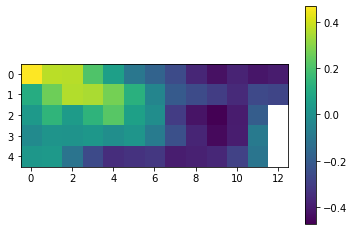

In [8]:
plt.imshow(correlation) ; plt.colorbar()

In [9]:
# 4 Cluster correlating region 
# Clustering is done with DBSCAN, and the distance metric is km (literally distance), calculated 
# by the haversine function (distance metric that takes into account curvature of the earth).
# by default we split the regions based on sign (positively and negatively correlation regions). 
# input data of function cluster_DBSCAN_regions should be xr.DataArray with shape (split, lag, latitude, longitude)

# to create empty xr.DataArray with right shape from input field:
lags = np.array([lag])
n_splits = 1
precur_arr = field_lag_1.copy() # Precursor field: only August period (08-01, 08-31) 
xrcorr = precur_arr.isel(anchor_year=0).drop('anchor_year').copy()
orig_mask = np.isnan(precur_arr[1]) # mask of first timestep? 
if 'lag' not in xrcorr.dims:
    # add lags
    list_xr = [xrcorr.expand_dims('lag', axis=0) for i in range(lags.size)]
    xrcorr = xr.concat(list_xr, dim = 'lag')
    xrcorr['lag'] = ('lag', lags)
# add train test split
list_xr = [xrcorr.expand_dims('split', axis=0) for i in range(n_splits)]
xrcorr = xr.concat(list_xr, dim = 'split')
xrcorr['split'] = ('split', range(n_splits))
xrpvals = xrcorr.copy()

In [10]:
# assign correlation value to xr.DataArray 
xrcorr[0,0] = correlation
xrpvals[0,0] = p_values
# create mask + add multiple hypothesis testing (from statsmodels)
# for simplicity
alpha = .05
# for mask, we also need to create axes for split and lag 
mask = (p_values < alpha)[None, None, :, :]
xrcorr['mask'] = (('split', 'lag', 'latitude', 'longitude'), mask==False)


# Clustering funtions


In [11]:
from s2spy.RGDR import map_regions

In [12]:
prec_labels = map_regions.cluster_DBSCAN_regions(corr_xr = xrcorr, 
                                                 distance_eps = 600, 
                                                 min_area_in_degrees2 = 3,
                                                 group_split = False,
                                                 group_lag = True,
                                                 n_jobs_clust = 1)

Progress traintest set 100%

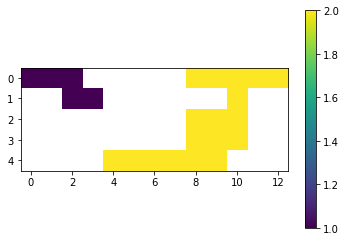

In [13]:
plt.imshow(prec_labels[0,0]) ; plt.colorbar()


<AxesSubplot:>

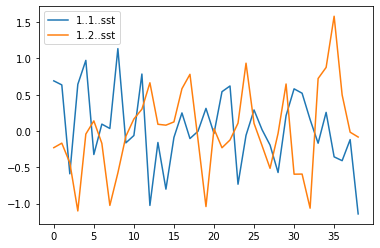

In [17]:
from s2spy.RGDR import map_regions


# Calculate spatial mean (feature) timeseries
df_tscorr = map_regions.spatial_mean_regions(precur_arr = field_lag_1.values, # to degrees,
                                             labels = prec_labels.sel(split=0).values, 
                                             lag_names = lags,
                                             name = 'sst')
df_tscorr.plot()                                            

<AxesSubplot:>

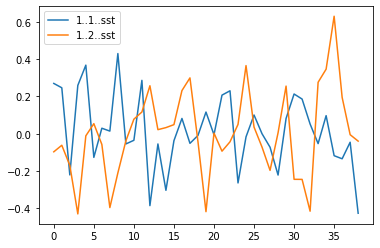

In [16]:
df_tscorr = map_regions.spatial_mean_regions(precur_arr = field_lag_1.values, # to degrees,
                                             labels = prec_labels.sel(split=0).values, 
                                             corr_wgts = xrcorr.sel(split=0).values,
                                             lag_names = lags,
                                             name = 'sst')
df_tscorr.plot()    